# LangGraph Components

**Key conetps**

- prompts (templates available at: https://smith.langchain.com/hub)
- tools (functions ran as actions)
- 
- cyclic graphs
- persistence
- human-in-the-loop
- 
- nodes (agents/functions)
- edges (connections)
- conditional edges
- 
- state (of an agent)

In [1]:
from typing import Literal
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
checkpointer = MemorySaver()

class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        self.tool_node = ToolNode(tools)

        graph = StateGraph(MessagesState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.tool_node)
        graph.add_conditional_edges("llm", self.exists_action)
        graph.add_edge("action", "llm")
        graph.add_edge(START, "llm")
        self.graph = graph.compile(checkpointer=checkpointer)

        self.tools = {tool.name: tool for tool in tools}
        self.model = model.bind_tools(tools)
    
    def call_openai(self, state: MessagesState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        response = self.model.invoke(messages)
        return {"messages": [response]}
    
    def exists_action(self, state: MessagesState) -> Literal["action", END]:
        last_result = state["messages"][-1]
        if last_result.tool_calls:
            return "action"
        return END

In [3]:
# Agent init
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-4-turbo", temperature=0)
tool = TavilySearchResults(max_results=2)

bot = Agent(model, [tool], system=prompt)

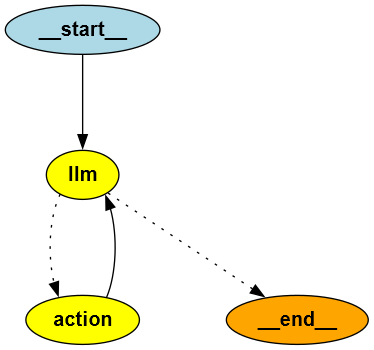

In [4]:
# View
from IPython.display import Image
Image(bot.graph.get_graph().draw_png())

In [5]:
# Query 1: simple graph execution
# Output mode 1: standard output

# Threading refers to managing many discussions at the same time
thread = {"configurable": {"thread_id": 1}}

# Q1
messages = [HumanMessage(content="What is the weather in Paris?")]
bot.graph.invoke({"messages": messages}, config=thread)
# Good to know: I learned through one of the model responses that there were 3 towns named Paris! (France, USA, and Canada)

# Q2
messages = [HumanMessage(content="Do you know how many subdivisions do that city counts")]
result = bot.graph.invoke({"messages": messages}, config=thread)
result

{'messages': [HumanMessage(content='What is the weather in Paris?', additional_kwargs={}, response_metadata={}, id='12a8992e-176e-42a9-b991-3c817bbfd995'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PJRSjfqOK5ut7rx3i6FN858T', 'function': {'arguments': '{"query":"current weather in Paris"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_cfb5f9efa7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-661c000a-64f7-443f-a2a3-c5a0d5d00363-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Paris'}, 'id': 'call_PJRS

In [6]:
# Query 2 (parallel execution -> backs to the model only once)
# Output mode 2: streaming messages

messages = [HumanMessage(content="What is the weather in Paris, France and Garoua, Cameroun?")]
thread = {"configurable": {"thread_id": 2}}

for event in bot.graph.stream({"messages": messages}, thread):
    for value in event.values():
        print(value["messages"])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Nd6B8DwdDuAp5JAR7V6mcGPg', 'function': {'arguments': '{"query": "current weather in Paris, France"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_rBNLL0QINOUzR9Y8QzgXEmA8', 'function': {'arguments': '{"query": "current weather in Garoua, Cameroon"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 163, 'total_tokens': 226, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_0f602ebbda', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e4538e02-6321-4c4e-b922-d1a622f73436-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weathe

In [7]:
# Query 3 (multiple model calls)
# Output mode 3: streaming tokens

messages = [HumanMessage(content="Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question.")]
thread = {"configurable": {"thread_id": 3}}

async for event in bot.graph.astream_events({"messages": messages}, thread, version="v1"):
    if event["event"] == "on_chat_model_stream":  # new token event
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")

1|.| The| winner| of| the| Super| Bowl| in| |202|4| was| the| Kansas| City| Chiefs|.
|2|.| The| headquarters| of| the| Kansas| City| Chiefs| is| located| in| Kansas| City|,| Missouri|.
|3|.| The| GDP| of| Missouri| in| |202|3| was| approximately| |344|.|12| billion| U|.S|.| dollars|.|